In [1]:
!pip install  --quiet langgraph
!pip install  --quiet langchain-google-genai
!pip install --quiet langchain
!pip install --quiet tavily-python langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.5 MB/s eta 0:00:00


In [21]:
!pip install --quiet langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 8.8 MB/s eta 0:00:00


In [65]:
from google.colab import userdata
from IPython.display import Image, display, Markdown
from typing_extensions import TypedDict
from typing import Dict, List
import textwrap

from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

from langchain_google_genai import ChatGoogleGenerativeAI


from langchain_core.prompts import ChatPromptTemplate

In [6]:
google_api_key = userdata.get('GOOGLE_API_KEY')

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                                                     api_key=google_api_key)

llm.invoke("What is your name?").content

'I am a large language model, trained by Google. I do not have a name. \n'

In [7]:
class State(TypedDict):
    city: str
    interests: List[str]
    response: str

def input_city(state: State):
  """LangGraph node that takes city input from the user"""
  city: str = input("What is your city?")
  state["city"] = city
  return {"city": city}

def input_interest(state: State):
  """LangGraph node that takes interest from the user"""
  interests: List[str] = []
  user_input = ''
  while user_input != "q":
    interests.append(user_input)
    user_input = input("Enter your interests. Enter 'q' when you are finished")
  state["interests"] = interests
  return {"interests": interests}

def generate_response(state: State):
  """LangGraph node that generates a travel planner for the user"""
  city: str = state["city"]
  interests: List[str] = state["interests"]
  prompt = ChatPromptTemplate.from_template(
      "You are an experience travel agent. You will create a traveling plan "
      "for the city {city} with the interests {interests}."
  )
  response = llm(prompt.format_messages(city=city, interests=interests))
  state["response"] = response.content
  return {"response": response.content}

In [8]:
graph: StateGraph = StateGraph(State)

graph.add_node("input_city", input_city)
graph.add_node("input_interest", input_interest)
graph.add_node("generate_response", generate_response)

graph.add_edge(START, "input_city")
graph.add_edge("input_city", "input_interest")
graph.add_edge("input_interest", "generate_response")
graph.add_edge("generate_response", END)

agent: CompiledStateGraph = graph.compile()

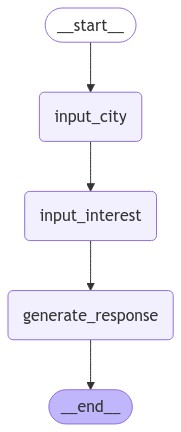

In [9]:
display(Image(agent.get_graph().draw_mermaid_png()))

In [15]:
result = agent.invoke({"city": 'Tokyo'})['response']

What is your city?London
Enter your interests. Enter 'q' when you are finishedHistorical Sites
Enter your interests. Enter 'q' when you are finishedq


In [19]:
def to_markdown(text)-> Markdown:
    text : str = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

to_markdown(result)

> ## London: A Journey Through Time - Historical Sites Edition
> 
> **Welcome to London, a city where history whispers around every corner!** This itinerary is designed to immerse you in the rich tapestry of London's past, from ancient Roman foundations to royal palaces and grand cathedrals.
> 
> **Day 1: Ancient Roots and Royal Splendor**
> 
> * **Morning:** Begin your journey at the **Tower of London**, a UNESCO World Heritage site steeped in history. Explore the infamous Tower, walk the ramparts, and learn about its role as a prison, royal residence, and treasury.
> * **Lunch:** Enjoy a traditional pub lunch near the Tower of London, savoring classic British fare.
> * **Afternoon:** Immerse yourself in the grandeur of **Buckingham Palace**, the official residence of the Queen. Witness the Changing of the Guard ceremony, a captivating spectacle steeped in tradition.
> * **Evening:** Indulge in a delicious dinner in the heart of **Mayfair**, renowned for its upscale dining and elegant atmosphere.
> 
> **Day 2: Gothic Majesty and Literary Legacy**
> 
> * **Morning:** Step back in time at **Westminster Abbey**, a masterpiece of Gothic architecture where monarchs have been crowned for centuries. Explore its intricate details and learn about its historical significance.
> * **Lunch:** Enjoy a picnic in **St. James's Park**, a tranquil oasis in the heart of the city, offering stunning views of Buckingham Palace.
> * **Afternoon:** Immerse yourself in the world of **Shakespeare's Globe Theatre**, a reconstruction of the original Elizabethan playhouse. Enjoy a performance or a guided tour to experience the magic of Shakespearean theatre.
> * **Evening:** Discover the literary heart of London at **Shakespeare's Birthplace** and the **British Library**, home to a vast collection of manuscripts and rare books.
> 
> **Day 3: Revolutionary Spirit and Modern Marvels**
> 
> * **Morning:** Explore the **Houses of Parliament**, the seat of the British government, and witness the iconic Big Ben clock tower.
> * **Lunch:** Enjoy a traditional fish and chips lunch at a local market in **Covent Garden**, a bustling hub of street performers and vibrant street food.
> * **Afternoon:** Discover the **National Gallery**, a world-renowned collection of European paintings spanning centuries. Marvel at masterpieces by Van Gogh, Monet, and Rembrandt.
> * **Evening:** Take a stroll along the **South Bank**, a vibrant cultural hub with modern art installations, street performers, and stunning views of the Thames.
> 
> **Bonus:**
> 
> * **Explore the Churchill War Rooms**, a fascinating underground bunker where Churchill led the nation during World War II.
> * **Visit the Imperial War Museums**, dedicated to the history of war and its impact on society.
> * **Take a walking tour of the City of London**, the historic financial district with Roman ruins and medieval churches.
> * **Explore the British Museum**, home to a vast collection of artifacts from around the world.
> 
> **This itinerary is just a starting point. Customize it to your interests and time constraints.** London offers a wealth of historical treasures waiting to be discovered. Enjoy your journey through time!
> 
> **Pro-Tip:** Consider purchasing a London Pass for access to numerous attractions and convenient travel options.